# Rehab Strength Dashboard – EDA Baseline

## Purpose
This notebook establishes the exploratory data analysis (EDA) foundation
for understanding training load, sleep behavior, and recovery signals
during rehabilitation.

The goal is not prediction, but clarity:
- What is normal?
- What is noise?
- What could indicate risk?


## Data Dictionary Reference

The full data dictionary for this project is maintained in:

`data_schema/data_dictionary.md`

This notebook assumes the definitions, granularity,
and limitations described there.


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates


## WORKOUTS

In [2]:
workouts = pd.read_csv("/Users/polux9589/Desktop/gym-ml-performance/data/raw/strong.csv")   #Upload workouts data
workouts.info()

<class 'pandas.DataFrame'>
RangeIndex: 6327 entries, 0 to 6326
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           6327 non-null   str    
 1   Workout Name   6327 non-null   str    
 2   Duration       6327 non-null   str    
 3   Exercise Name  6327 non-null   str    
 4   Set Order      6327 non-null   str    
 5   Weight         6327 non-null   float64
 6   Reps           6327 non-null   float64
 7   Distance       6327 non-null   int64  
 8   Seconds        6327 non-null   float64
 9   Notes          185 non-null    str    
 10  Workout Notes  0 non-null      float64
 11  RPE            4458 non-null   float64
dtypes: float64(5), int64(1), str(6)
memory usage: 593.3 KB


In [3]:
workouts.columns

Index(['Date', 'Workout Name', 'Duration', 'Exercise Name', 'Set Order',
       'Weight', 'Reps', 'Distance', 'Seconds', 'Notes', 'Workout Notes',
       'RPE'],
      dtype='str')

In [4]:
workouts.describe(include="all")

,Date,Workout Name,Duration,Exercise Name,Set Order,Weight,Reps,Distance,Seconds,Notes,Workout Notes,RPE
count,6327,6327,6327,6327,6327,6327.000000,6327.000000,6327.0,6327.000000,185,0.0,4458.000000
unique,199,17,61,70,11,NaN,NaN,NaN,NaN,37,NaN,NaN
top,2025-12-19 10:49:20,CHEST & BACK,1h 25m,Incline Bench Press (Barbell),Rest Timer,NaN,NaN,NaN,NaN,Machine brand: LifeFitness,NaN,NaN
freq,67,984,332,327,1615,NaN,NaN,NaN,NaN,46,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,67.315157,7.954481,0.0,34.392919,NaN,NaN,8.022880
std,NaN,NaN,NaN,NaN,NaN,67.659043,5.259003,0.0,59.984666,NaN,NaN,1.079067
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,6.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,7.000000
50%,NaN,NaN,NaN,NaN,NaN,50.000000,10.000000,0.0,0.000000,NaN,NaN,8.000000
75%,NaN,NaN,NaN,NaN,NaN,105.000000,12.000000,0.0,100.000000,NaN,NaN,9.000000


In [5]:
workouts.shape

(6327, 12)

In [6]:
workouts["Date"]= pd.to_datetime(workouts["Date"], format="%Y-%m-%d %H:%M:%S")
workouts["Date"] = workouts["Date"].dt.date
workouts["Date"]

0       2024-09-22
1       2024-09-22
2       2024-09-22
3       2024-09-22
4       2024-09-22
           ...    
6322    2026-01-26
6323    2026-01-26
6324    2026-01-26
6325    2026-01-26
6326    2026-01-26
Name: Date, Length: 6327, dtype: object

## SLEEP

In [7]:
sleep = pd.read_excel("/Users/polux9589/Desktop/gym-ml-performance/data/raw/Sleep_Garmin.xlsx")  #Upload sleep data
sleep.info()

<class 'pandas.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Sleep Score 4 Weeks  42 non-null     datetime64[us]
 1   Score                42 non-null     int64         
 2   Resting Heart Rate   42 non-null     int64         
 3   Body Battery         42 non-null     int64         
 4   Pulse Ox             42 non-null     str           
 5   Respiration          42 non-null     float64       
 6   HRV Status           42 non-null     int64         
 7   Quality              42 non-null     str           
 8   Duration             42 non-null     str           
 9   Sleep Need           42 non-null     str           
 10  Bedtime              42 non-null     object        
 11  Wake Time            42 non-null     object        
dtypes: datetime64[us](1), float64(1), int64(4), object(2), str(4)
memory usage: 4.1+ KB


In [8]:
sleep.shape

(42, 12)

In [9]:
sleep.columns

Index(['Sleep Score 4 Weeks', 'Score', 'Resting Heart Rate', 'Body Battery',
       'Pulse Ox', 'Respiration', 'HRV Status', 'Quality', 'Duration',
       'Sleep Need', 'Bedtime', 'Wake Time'],
      dtype='str')

In [10]:
sleep.sample(10)

,Sleep Score 4 Weeks,Score,Resting Heart Rate,Body Battery,Pulse Ox,Respiration,HRV Status,Quality,Duration,Sleep Need,Bedtime,Wake Time
17,2026-01-02,95,42,50,--,15.10,47,Excellent,8h 3min,8h 0min,23:16:00,07:20:00
21,2026-01-06,86,42,60,--,14.88,48,Good,7h 38min,8h 0min,22:36:00,06:39:00
31,2026-01-16,79,41,49,93.85,14.78,46,Fair,6h 12min,8h 0min,00:30:00,06:46:00
2,2025-12-18,80,44,55,--,15.29,47,Good,6h 34min,7h 0min,22:31:00,05:06:00
35,2026-01-20,81,42,51,93.38,14.87,46,Good,7h 1min,7h 40min,00:24:00,07:59:00
22,2026-01-07,88,42,58,--,15.40,48,Good,7h 44min,8h 0min,22:29:00,06:15:00
20,2026-01-05,87,42,53,--,14.92,48,Good,6h 56min,8h 0min,23:23:00,06:19:00
27,2026-01-12,87,42,54,92.39,14.71,47,Good,7h 34min,7h 30min,22:46:00,06:30:00
4,2025-12-20,91,43,63,--,14.75,44,Excellent,7h 55min,8h 0min,22:22:00,06:20:00
25,2026-01-10,79,43,52,--,16.00,46,Fair,9h 50min,7h 40min,22:39:00,09:19:00


In [11]:
sleep.describe(include="all")

,Sleep Score 4 Weeks,Score,Resting Heart Rate,Body Battery,Pulse Ox,Respiration,HRV Status,Quality,Duration,Sleep Need,Bedtime,Wake Time
count,42,42.000000,42.000000,42.000000,42,42.000000,42.000000,42,42,42,42,42
unique,NaN,NaN,NaN,NaN,15,NaN,NaN,3,39,9,36,34
top,NaN,NaN,NaN,NaN,--,NaN,NaN,Good,8h 3min,8h 0min,22:00:00,06:15:00
freq,NaN,NaN,NaN,NaN,26,NaN,NaN,25,2,24,3,5
mean,2026-01-12 00:00:00,84.214286,42.666667,54.619048,NaN,15.417381,46.333333,NaN,NaN,NaN,NaN,NaN
min,2025-12-16 00:00:00,63.000000,40.000000,30.000000,NaN,14.450000,43.000000,NaN,NaN,NaN,NaN,NaN
25%,2025-12-26 06:00:00,79.250000,42.000000,51.000000,NaN,14.925000,46.000000,NaN,NaN,NaN,NaN,NaN
50%,2026-01-05 12:00:00,86.000000,42.500000,54.000000,NaN,15.460000,46.000000,NaN,NaN,NaN,NaN,NaN
75%,2026-01-15 18:00:00,87.000000,43.000000,58.000000,NaN,15.785000,47.000000,NaN,NaN,NaN,NaN,NaN
max,2026-10-22 00:00:00,98.000000,48.000000,68.000000,NaN,16.810000,48.000000,NaN,NaN,NaN,NaN,NaN


## HRV

In [12]:
hrv = pd.read_excel("/Users/polux9589/Desktop/gym-ml-performance/data/raw/HRV_Status.xlsx")  #Upload HRV data
hrv.info()

<class 'pandas.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           42 non-null     datetime64[us]
 1   Overnight HRV  42 non-null     str           
 2   Baseline       42 non-null     str           
 3   7d Avg         42 non-null     str           
 4   Stress         41 non-null     float64       
 5   RHR            42 non-null     int64         
dtypes: datetime64[us](1), float64(1), int64(1), str(3)
memory usage: 2.1 KB


In [13]:
hrv.columns

Index(['Date', 'Overnight HRV', 'Baseline', '7d Avg', 'Stress', 'RHR'], dtype='str')

In [14]:
hrv.shape

(42, 6)

In [15]:
hrv.describe(include="all")

,Date,Overnight HRV,Baseline,7d Avg,Stress,RHR
count,42,42,42,42,41.000000,42.000000
unique,NaN,14,5,6,NaN,NaN
top,NaN,47ms,45ms - 53ms,46ms,NaN,NaN
freq,NaN,5,18,14,NaN,NaN
mean,2026-01-05 12:00:00,NaN,NaN,NaN,25.804878,42.666667
min,2025-12-16 00:00:00,NaN,NaN,NaN,19.000000,40.000000
25%,2025-12-26 06:00:00,NaN,NaN,NaN,23.000000,42.000000
50%,2026-01-05 12:00:00,NaN,NaN,NaN,25.000000,42.500000
75%,2026-01-15 18:00:00,NaN,NaN,NaN,29.000000,43.000000
max,2026-01-26 00:00:00,NaN,NaN,NaN,38.000000,48.000000


# DAY 2

In [16]:
trim_mean = stats.trim_mean(sleep["Score"], proportiontocut=0.1)
trim_mean

np.float64(84.38235294117646)

In [17]:
mean = sleep["Score"].mean()
mean

np.float64(84.21428571428571)

In [18]:
median = sleep["Score"].median()
median

np.float64(86.0)

In [19]:
weighted_mean = np.average(sleep["Score"], weights=sleep["HRV Status"])
weighted_mean

np.float64(84.21017471736896)

In [20]:
std_score = sleep["Score"].std(ddof=1)
std_score

np.float64(6.30344742798351)

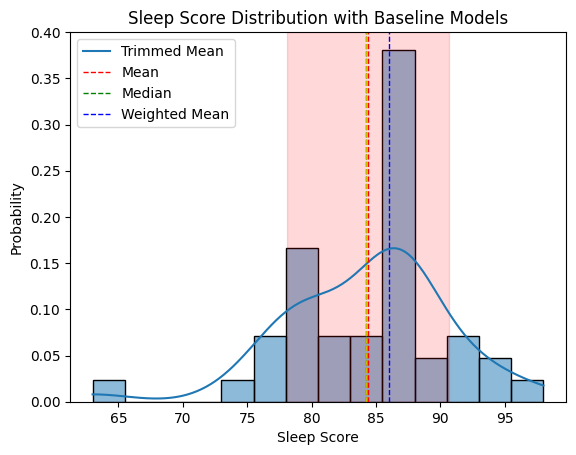

In [21]:
sns.histplot(sleep["Score"], kde=True, stat="probability", binwidth=2.5)
plt.axvline(trim_mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(median, color='b', linestyle='dashed', linewidth=1)
plt.axvline(weighted_mean, color='y', linestyle='dashed', linewidth=1)
plt.axvspan(trim_mean - std_score, trim_mean + std_score, alpha=0.15, color='r')
plt.legend({'Trimmed Mean':trim_mean,'Mean':mean,'Median':median,'Weighted Mean':weighted_mean})
plt.title('Sleep Score Distribution with Baseline Models')
plt.xlabel('Sleep Score')
plt.ylabel('Probability')
plt.show()

In [22]:
def normality_test(data):
    stat, pvalue = stats.shapiro(data)
    if pvalue > 0.05:
        return print(f"The data follows a normal distribution (fail to reject H0) {pvalue:.5f}")
    else:
        return print(f"The data does not follow a normal distribution (reject H0) {pvalue:.5f}")

normality_test(sleep["Score"])

The data does not follow a normal distribution (reject H0) 0.02495


In [23]:
sleep = sleep.rename(columns={"Sleep Score 4 Weeks":"Date"})
sleep.info()

<class 'pandas.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                42 non-null     datetime64[us]
 1   Score               42 non-null     int64         
 2   Resting Heart Rate  42 non-null     int64         
 3   Body Battery        42 non-null     int64         
 4   Pulse Ox            42 non-null     str           
 5   Respiration         42 non-null     float64       
 6   HRV Status          42 non-null     int64         
 7   Quality             42 non-null     str           
 8   Duration            42 non-null     str           
 9   Sleep Need          42 non-null     str           
 10  Bedtime             42 non-null     object        
 11  Wake Time           42 non-null     object        
dtypes: datetime64[us](1), float64(1), int64(4), object(2), str(4)
memory usage: 4.1+ KB


In [24]:
sleep["HRV Status"].describe()

count    42.000000
mean     46.333333
std       1.300406
min      43.000000
25%      46.000000
50%      46.000000
75%      47.000000
max      48.000000
Name: HRV Status, dtype: float64

In [25]:
mean_hrv = sleep["HRV Status"].mean()
weighted_mean_hrv = np.average(sleep["HRV Status"], weights=sleep["Score"])
trim_mean_hrv = stats.trim_mean(sleep["HRV Status"], proportiontocut=0.1)
median_hrv = sleep["HRV Status"].median()
std_hrv = sleep["HRV Status"].std(ddof=1)

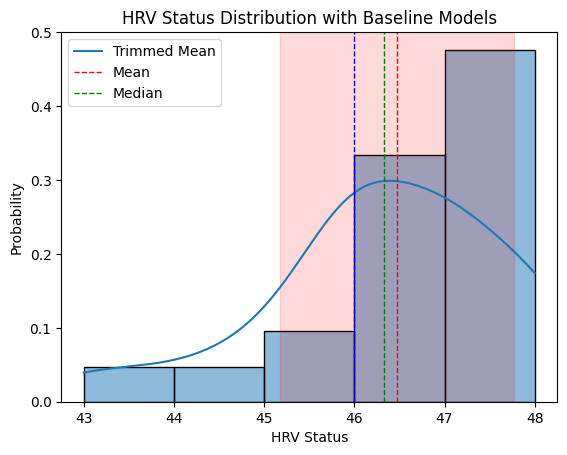

The data does not follow a normal distribution (reject H0) 0.00079


In [26]:
sns.histplot(sleep["HRV Status"], kde=True, stat="probability", binwidth=1)
plt.axvline(trim_mean_hrv, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean_hrv, color='g', linestyle='dashed', linewidth=1)
plt.axvline(median_hrv, color='b', linestyle='dashed', linewidth=1)
plt.axvspan(trim_mean_hrv - std_hrv, trim_mean_hrv + std_hrv, alpha=0.15, color='r')
plt.legend({'Trimmed Mean':trim_mean_hrv,'Mean':mean_hrv,'Median':median_hrv})
plt.title('HRV Status Distribution with Baseline Models')
plt.xlabel('HRV Status')
plt.ylabel('Probability')
plt.show()

normality_test(sleep["HRV Status"])

In [27]:
test = pd.read_csv("/Users/polux9589/Desktop/GYM WORKOUT ANALYSIS PROJECT/processed_data/clean_sleep_data.csv")

In [28]:
test.columns

Index(['Date', 'Main_x', 'Start', 'End', 'InBed hrs', 'Asleep hrs', 'Awake',
       'REM hrs', 'Light hrs', 'Deep hrs', 'Wake Count', 'Efficiency',
       'Fall Asleep', 'Data Source', 'Main_y', 'Start_Nap', 'End_Nap',
       'Asleep_Nap', 'Data Source Nap', 'Overnight HRV', 'Baseline', '7d Avg',
       'Stress', 'RHR'],
      dtype='str')

In [29]:
test.info()

<class 'pandas.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             435 non-null    str    
 1   Main_x           435 non-null    bool   
 2   Start            435 non-null    str    
 3   End              435 non-null    str    
 4   InBed hrs        435 non-null    float64
 5   Asleep hrs       435 non-null    float64
 6   Awake            435 non-null    int64  
 7   REM hrs          333 non-null    float64
 8   Light hrs        335 non-null    float64
 9   Deep hrs         335 non-null    float64
 10  Wake Count       435 non-null    int64  
 11  Efficiency       435 non-null    str    
 12  Fall Asleep      332 non-null    float64
 13  Data Source      435 non-null    str    
 14  Main_y           28 non-null     object 
 15  Start_Nap        28 non-null     str    
 16  End_Nap          28 non-null     str    
 17  Asleep_Nap       28 non-nul

In [30]:
test.describe()

,InBed hrs,Asleep hrs,Awake,REM hrs,Light hrs,Deep hrs,Wake Count,Fall Asleep,Asleep_Nap,Overnight HRV,7d Avg,Stress,RHR
count,435.000000,435.000000,435.000000,333.000000,335.000000,335.000000,435.000000,332.000000,28.000000,126.000000,126.000000,126.000000,126.000000
mean,7.411571,7.096782,18.206897,1.626376,4.177910,1.612139,3.144828,0.316265,37.357143,46.603175,46.333333,26.476190,42.380952
std,1.394969,1.273028,29.701874,0.556963,0.880114,0.382560,4.307821,5.762624,27.394531,4.141651,1.959592,4.424865,1.792684
min,4.450000,2.083333,0.000000,0.116667,2.033333,0.000000,0.000000,0.000000,15.000000,37.000000,41.000000,16.000000,38.000000
25%,6.433333,6.216667,1.000000,1.266667,3.616667,1.383333,1.000000,0.000000,25.750000,44.000000,45.000000,24.000000,41.000000
50%,7.283333,7.033333,9.000000,1.616667,4.100000,1.650000,2.000000,0.000000,30.000000,47.000000,47.000000,26.000000,42.000000
75%,8.100000,7.858333,22.000000,1.933333,4.700000,1.866667,4.000000,0.000000,30.000000,49.750000,48.000000,29.000000,43.000000
max,15.050000,11.766667,265.000000,3.633333,7.016667,2.633333,34.000000,105.000000,158.000000,56.000000,50.000000,39.000000,48.000000


# DAY 3

In [31]:
test.columns

Index(['Date', 'Main_x', 'Start', 'End', 'InBed hrs', 'Asleep hrs', 'Awake',
       'REM hrs', 'Light hrs', 'Deep hrs', 'Wake Count', 'Efficiency',
       'Fall Asleep', 'Data Source', 'Main_y', 'Start_Nap', 'End_Nap',
       'Asleep_Nap', 'Data Source Nap', 'Overnight HRV', 'Baseline', '7d Avg',
       'Stress', 'RHR'],
      dtype='str')

## Asleep hrs Metric

In [32]:
mean_hrv = test["Asleep hrs"].mean()
trim_mean_hrv = stats.trim_mean(test["Asleep hrs"], proportiontocut=0.1)
median_hrv = test["Asleep hrs"].median()
std_hrv = test["Asleep hrs"].std(ddof=1)
variability_hrv = std_hrv / mean_hrv

print(f"Mean: {mean_hrv}, Trimmed Mean: {trim_mean_hrv},\nMedian: {median_hrv}, Std Dev: {std_hrv}, Variability: {variability_hrv}")

Mean: 7.096781609195402, Trimmed Mean: 7.061270296084049,
Median: 7.033333333333333, Std Dev: 1.2730284746440061, Variability: 0.17938109762241025


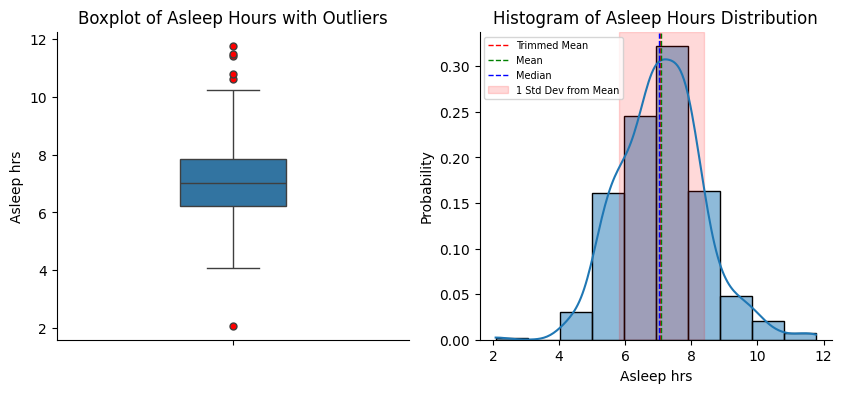

Outliers: 6
Total data points: 435
lower bound: 3.754166666666668, upper bound: 10.320833333333331


In [33]:
fig, ax = plt.subplots(1,2 , figsize=(10,4))
sns.boxplot(test["Asleep hrs"],
             fliersize=2, flierprops=dict(markerfacecolor='r', marker='o', markersize=5),
            width=0.3, ax=ax[0])
ax[0].set_title('Boxplot of Asleep Hours with Outliers')
sns.despine(ax=ax[0])

sns.histplot(test["Asleep hrs"], kde=True, stat="probability", binwidth=1, fill=True, ax=ax[1])
ax[1].axvline(trim_mean_hrv, color='r', linestyle='dashed', linewidth=1, label='Trimmed Mean')
ax[1].axvline(mean_hrv, color='g', linestyle='dashed', linewidth=1, label='Mean')
ax[1].axvline(median_hrv, color='b', linestyle='dashed', linewidth=1, label='Median')
ax[1].axvspan(mean_hrv - std_hrv, mean_hrv + std_hrv, alpha=0.15, color='r', label='1 Std Dev from Mean')
ax[1].set_title('Histogram of Asleep Hours Distribution')
ax[1].legend(loc="upper left", fontsize=7)
sns.despine(ax=ax[1])
plt.show()

q1 = test["Asleep hrs"].quantile(0.25)
q3 = test["Asleep hrs"].quantile(0.75)
IQR = q3 - q1
outliers = test[(test["Asleep hrs"] < q1 - 1.5 * IQR) | (test["Asleep hrs"] > q3 + 1.5 * IQR)]
print(f"Outliers: {len(outliers)}")
print(f"Total data points: {test["Asleep hrs"].shape[0]}")
print(f"lower bound: {q1 - 1.5 * IQR}, upper bound: {q3 + 1.5 * IQR}")

In [34]:
test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d")

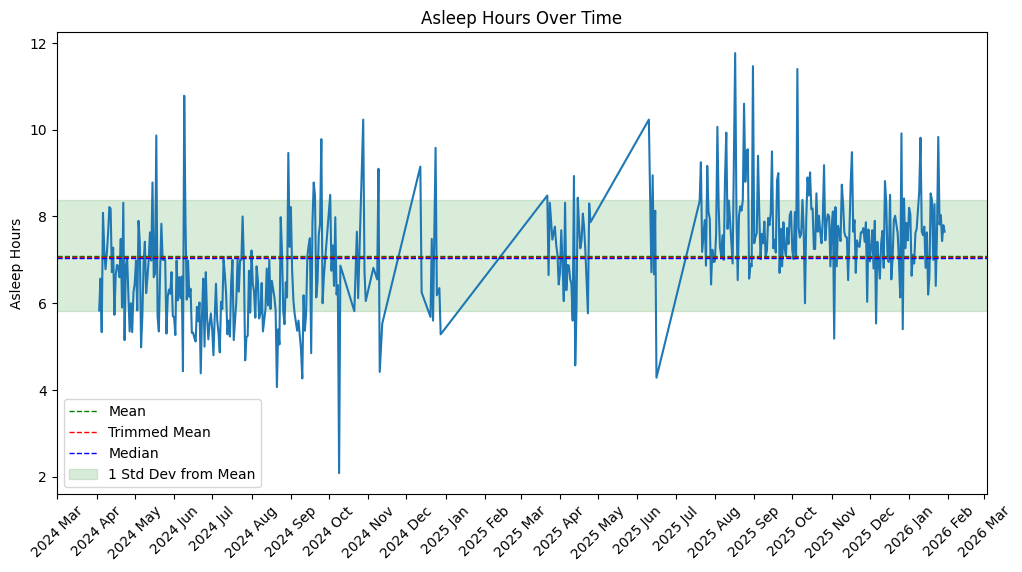

In [35]:
plt.figure(figsize=(12,6))
sns.lineplot(data=test, x="Date", y="Asleep hrs", estimator="mean")
plt.axhline(mean_hrv, color='g', linestyle='dashed', linewidth=1, label='Mean')
plt.axhline(trim_mean_hrv, color='r', linestyle='dashed', linewidth=1, label='Trimmed Mean')
plt.axhline(median_hrv, color='b', linestyle='dashed', linewidth=1, label='Median')
plt.axhspan(mean_hrv-std_hrv, mean_hrv+std_hrv, alpha=0.15, color='g', label='1 Std Dev from Mean')
plt.legend()
plt.title("Asleep Hours Over Time")
plt.xlabel("")
plt.ylabel("Asleep Hours")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
plt.xticks(rotation=45)
plt.show()


## STRESS

In [36]:
mean_stress = test["Stress"].mean()
median_stress = test["Stress"].median()
trim_mean_stress = stats.trim_mean(test["Stress"].dropna(), proportiontocut=0.25)
std_stress = test["Stress"].std(ddof=1)
variablity = std_stress / mean_stress

print(f"Mean: {mean_stress}, Median: {median_stress}, Trimmed Mean: {trim_mean_stress},\nStd Dev: {std_stress}, Variability: {variablity}")


Mean: 26.476190476190474, Median: 26.0, Trimmed Mean: 26.0,
Std Dev: 4.4248648082657365, Variability: 0.16712618880140373


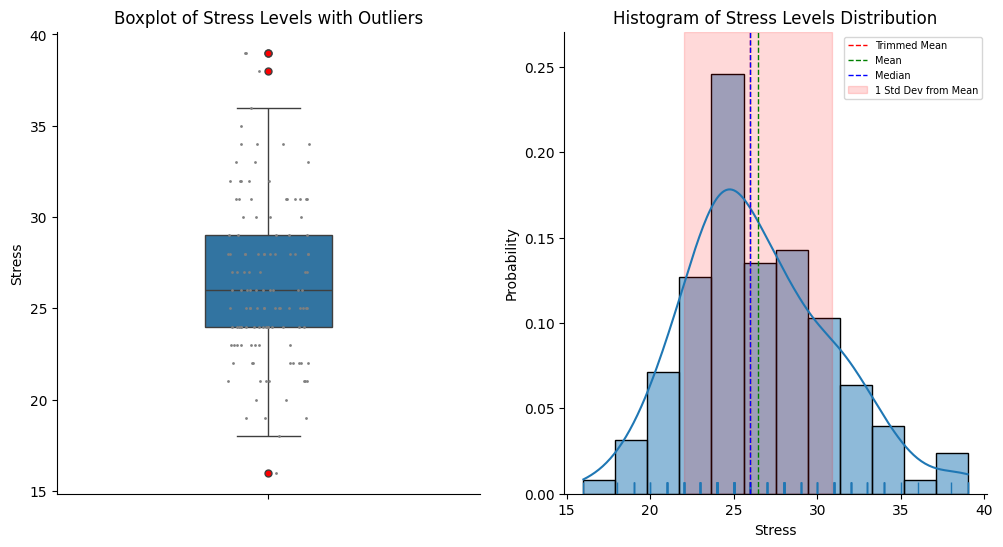

Outliers: 4
Total data points: 435
lower bound: 16.5, upper bound: 36.5


In [37]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(test["Stress"], fliersize=2, flierprops=dict(markerfacecolor="red", marker="o", markersize=5),
             width=0.3, ax=ax[0])
sns.stripplot(test["Stress"], color="grey", size=2, ax=ax[0])
ax[0].set_title('Boxplot of Stress Levels with Outliers')
sns.despine(ax=ax[0])
sns.histplot(test["Stress"], kde=True, stat="probability", fill=True, ax=ax[1])
sns.rugplot(test["Stress"], ax=ax[1])
ax[1].set_title('Histogram of Stress Levels Distribution')
ax[1].axvline(trim_mean_stress, color='r', linestyle='dashed', linewidth=1, label='Trimmed Mean')
ax[1].axvline(mean_stress, color='g', linestyle='dashed', linewidth=1, label='Mean')
ax[1].axvline(median_stress, color='b', linestyle='dashed', linewidth=1, label='Median')
ax[1].axvspan(mean_stress - std_stress, mean_stress + std_stress, alpha=0.15, color='r', label='1 Std Dev from Mean')
ax[1].legend(loc="upper right", fontsize=7)
sns.despine(ax=ax[1])
plt.show()

q1_stress = test["Stress"].quantile(0.25)
q3_stress = test["Stress"].quantile(0.75)
IQR_stress = q3_stress - q1_stress
outliers_stress = test[(test["Stress"] < q1_stress - 1.5 * IQR_stress) | (test["Stress"] > q3_stress + 1.5 * IQR_stress)]
print(f"Outliers: {len(outliers_stress)}")
print(f"Total data points: {test["Stress"].shape[0]}")
print(f"lower bound: {q1_stress - 1.5 * IQR_stress}, upper bound: {q3_stress + 1.5 * IQR_stress}")

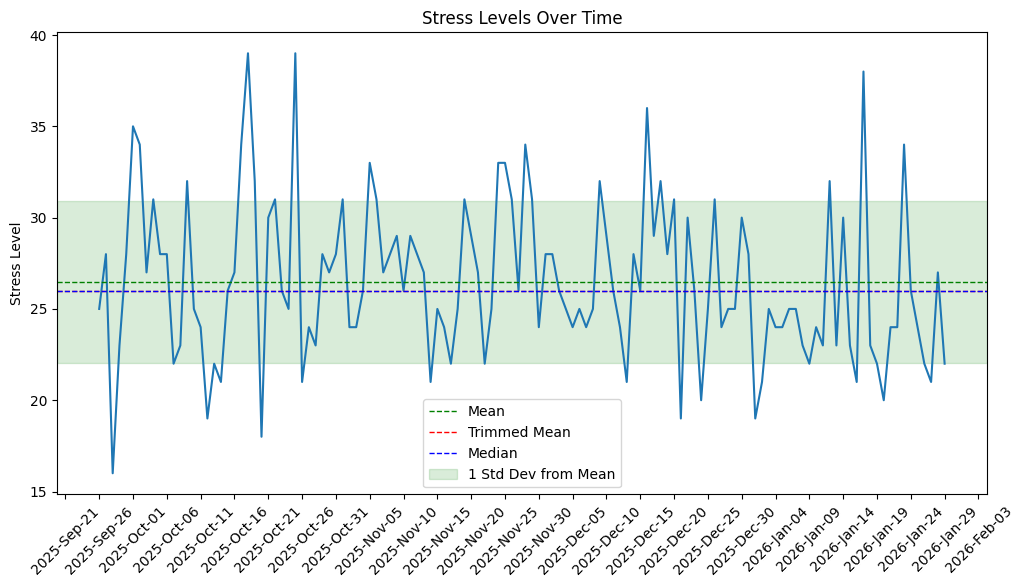

In [38]:
plt.figure(figsize=(12,6))
sns.lineplot(data=test, x="Date", y="Stress", estimator="mean")
plt.title("Stress Levels Over Time")
plt.xlabel("")
plt.ylabel("Stress Level")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b-%d"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.axhline(mean_stress, color='g', linestyle='dashed', linewidth=1, label='Mean')
plt.axhline(trim_mean_stress, color='r', linestyle='dashed', linewidth=1, label='Trimmed Mean')
plt.axhline(median_stress, color='b', linestyle='dashed', linewidth=1, label='Median')
plt.axhspan(mean_stress - std_stress, mean_stress + std_stress, alpha=0.15, color='g', label='1 Std Dev from Mean')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## DAY 5

In [39]:
recovery = pd.read_csv("/Users/polux9589/Desktop/GYM WORKOUT ANALYSIS PROJECT/processed_data/clean_recovery_data.csv")
recovery.info()

<class 'pandas.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    435 non-null    str    
 1   Main_x                  435 non-null    bool   
 2   Start                   435 non-null    str    
 3   End                     435 non-null    str    
 4   InBed hrs               435 non-null    float64
 5   Asleep hrs              435 non-null    float64
 6   Awake                   435 non-null    int64  
 7   REM hrs                 333 non-null    float64
 8   Light hrs               335 non-null    float64
 9   Deep hrs                335 non-null    float64
 10  Wake Count              435 non-null    int64  
 11  Efficiency              435 non-null    str    
 12  Fall Asleep             332 non-null    float64
 13  Data Source             435 non-null    str    
 14  Main_y                  28 non-null     object 
 15  

In [48]:
recovery["Date"] = pd.to_datetime(recovery["Date"], format="%Y-%m-%d")
recovery = recovery.sort_values(by="Date")
recovery = recovery[recovery["Main_x"] == True].copy()
recovery = recovery.dropna(subset=["Overnight HRV"], axis=0)
recovery.info()

<class 'pandas.DataFrame'>
RangeIndex: 126 entries, 309 to 434
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    126 non-null    datetime64[us]
 1   Main_x                  126 non-null    bool          
 2   Start                   126 non-null    str           
 3   End                     126 non-null    str           
 4   InBed hrs               126 non-null    float64       
 5   Asleep hrs              126 non-null    float64       
 6   Awake                   126 non-null    int64         
 7   REM hrs                 126 non-null    float64       
 8   Light hrs               126 non-null    float64       
 9   Deep hrs                126 non-null    float64       
 10  Wake Count              126 non-null    int64         
 11  Efficiency              126 non-null    str           
 12  Fall Asleep             123 non-null    float64       
 13 

In [49]:
pd.set_option('display.max_columns', None)
recovery.head()

,Date,Main_x,Start,End,InBed hrs,Asleep hrs,Awake,REM hrs,Light hrs,Deep hrs,Wake Count,Efficiency,Fall Asleep,Data Source,Main_y,Start_Nap,End_Nap,Asleep_Nap,Data Source Nap,Overnight HRV,Baseline,7d Avg,Stress,RHR,Score,Resting Heart Rate,Body Battery,Pulse Ox,Respiration,HRV Status,Quality,Duration,Sleep Need,Bedtime,Wake Time,Stress_prev_day,Z Asleep hrs,Z Overnight HRV,Z Resting Heart Rate,Z Score,Z Stress_prev_day,RECOVERY_SCORE_RAW,Sigmoid Recovery Score,End_Nap_Decimal,Start_Nap_Decimal,Nap_Classifier,Nap_Duration_Score,Nap Status,Sigmoid with Nap,DELTA_NAP
309,2025-09-26,True,23:39,06:57,7.283333,7.083333,12,1.500000,3.783333,1.800000,3,97%,0.0,Connect,False,16:04,17:17,73.0,Connect,46.0,42ms - 53ms,44.0,25.0,43.0,83.0,43.0,56.0,92.86,14.70,44.0,Good,7h 5min,7h 30min,23:39:00,06:57:00,NaN,-0.010576,-0.146218,-0.346697,-0.313663,NaN,NaN,NaN,17.283333,16.066667,-0.5,0.1,Disrupt ⚠️,NaN,NaN
310,2025-09-27,True,22:43,06:31,7.800000,7.733333,3,1.950000,3.900000,1.883333,2,99%,0.0,Connect,NaN,NaN,NaN,NaN,NaN,43.0,43ms - 53ms,43.0,28.0,44.0,91.0,44.0,52.0,93.24,15.81,43.0,Excellent,7h 45min,7h 0min,22:43:00,06:31:00,25.0,0.500605,-0.873458,-0.906747,0.971591,0.343124,0.007023,0.501756,NaN,NaN,0.0,0.0,No Nap,0.501756,0.000000
311,2025-09-28,True,23:21,06:46,7.416667,7.366667,3,1.333333,4.666667,1.350000,1,99%,0.0,Connect,NaN,NaN,NaN,NaN,NaN,54.0,43ms - 53ms,44.0,16.0,43.0,92.0,43.0,65.0,94.75,15.82,44.0,Excellent,7h 22min,7h 30min,23:21:00,06:46:00,28.0,0.212246,1.793090,-0.346697,1.132248,-0.337678,0.490642,0.620258,NaN,NaN,0.0,0.0,No Nap,0.620258,0.000000
312,2025-09-29,True,21:57,06:10,8.200000,8.033333,10,2.150000,4.433333,1.433333,2,98%,0.0,Connect,NaN,NaN,NaN,NaN,NaN,56.0,43ms - 52ms,45.0,23.0,41.0,93.0,41.0,47.0,94.36,15.33,45.0,Excellent,8h 2min,8h 0min,21:57:00,06:10:00,16.0,0.736535,2.277917,0.773402,1.292905,2.385529,1.493258,0.816567,NaN,NaN,0.0,0.0,No Nap,0.816567,0.000000
313,2025-09-30,True,21:57,06:10,8.216667,8.116667,5,2.050000,4.050000,2.016667,1,99%,0.0,Connect,False,14:30,15:00,30.0,Connect,51.0,42ms - 52ms,47.0,28.0,41.0,94.0,41.0,61.0,92,15.00,47.0,Excellent,8h 8min,7h 40min,21:57:00,06:10:00,23.0,0.802071,1.065850,0.773402,1.453561,0.796992,0.978375,0.726786,15.000000,14.500000,0.5,0.5,Boost 🔥,1.000000,0.273214


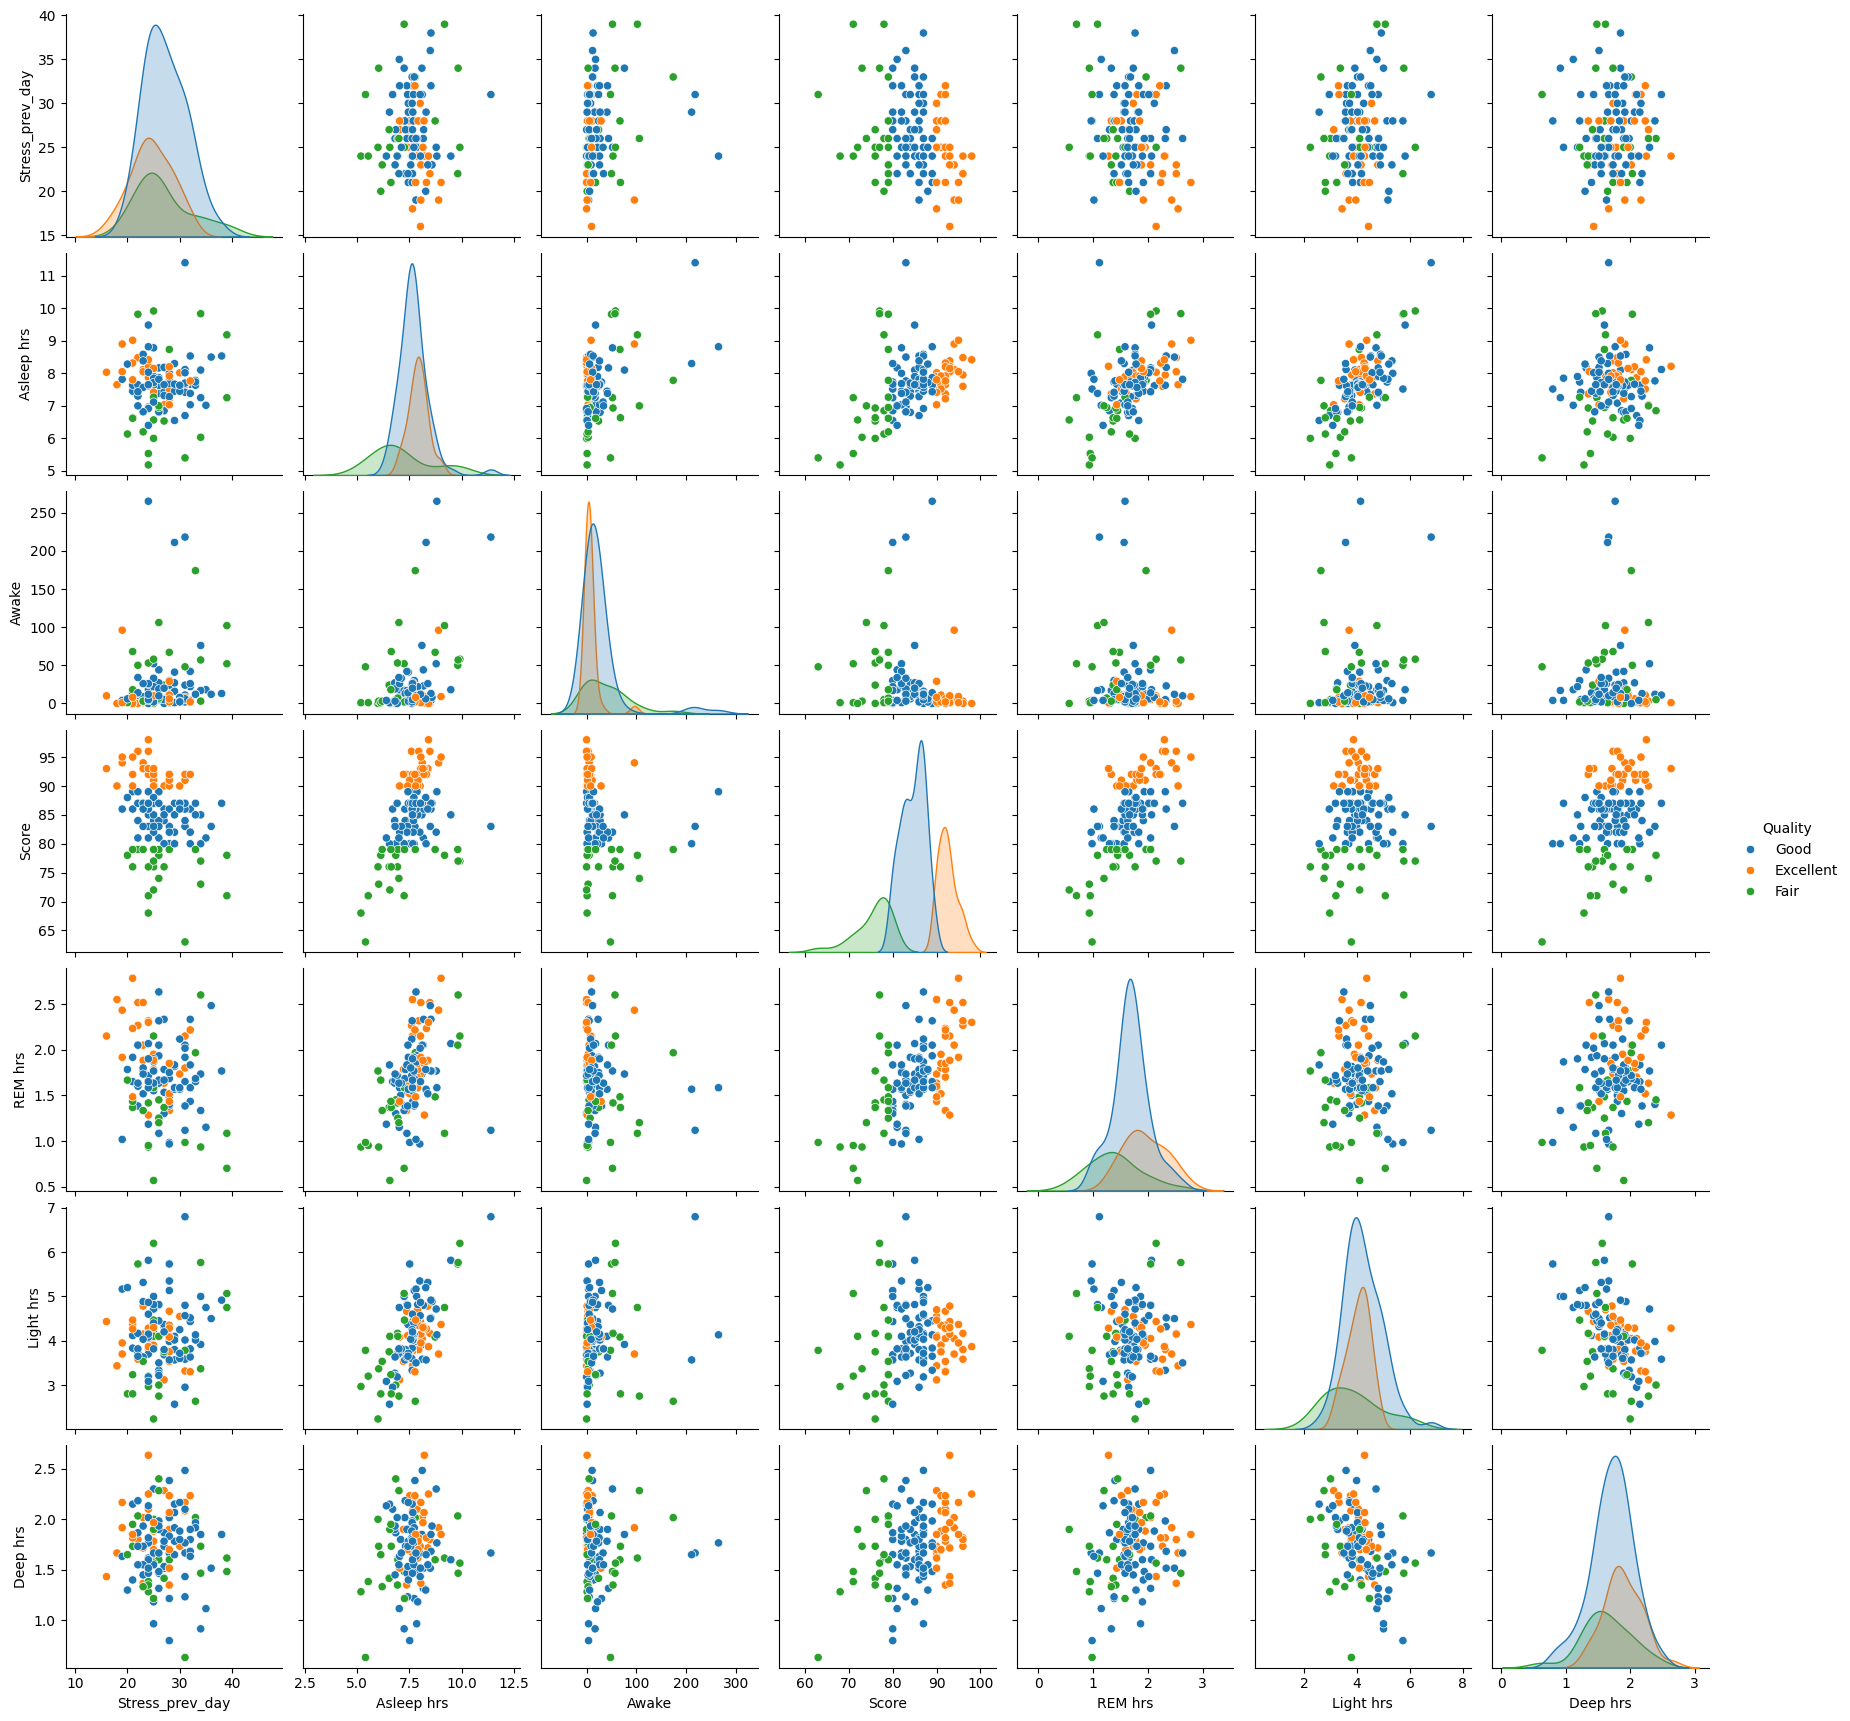

In [57]:
# METRICS: SCORE - Stress_prev_day, Asleep hrs, Awake 

features = ["Stress_prev_day", "Asleep hrs", "Awake", "Score"]

sns.pairplot(recovery[features + ["Quality"]+ ["REM hrs", "Light hrs", "Deep hrs" ]], hue="Quality")


<Axes: >

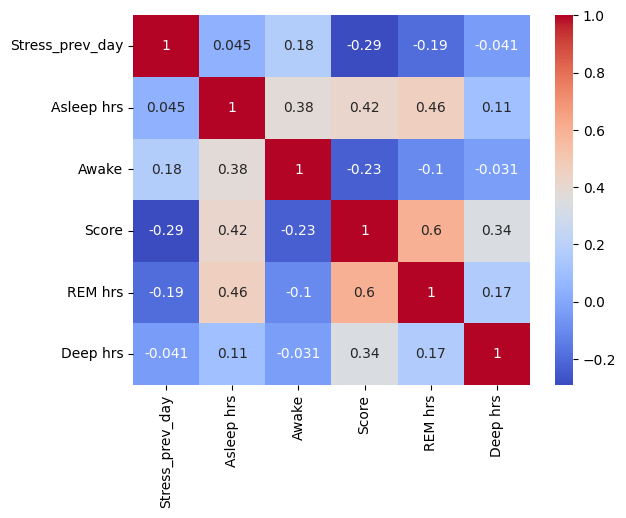

In [58]:
correlation = recovery[features + ["REM hrs", "Deep hrs"]].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")

Moderate positive correlation between Score and REM hrs

Moderate to low positive correlation between Score and Asleep hrs

Weak positive correlation between Score and Deep hrs

Moderate to low negative correlation between Score and Stress on previous day

Weak negative correlation between Score and Awake


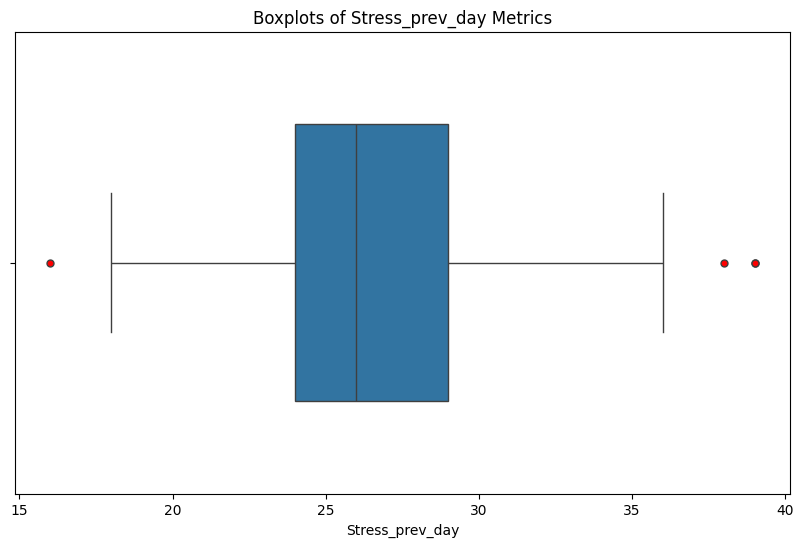

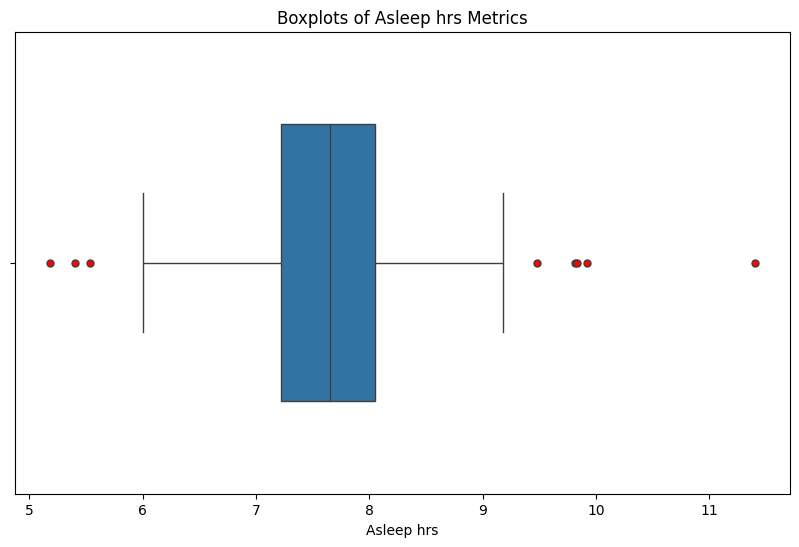

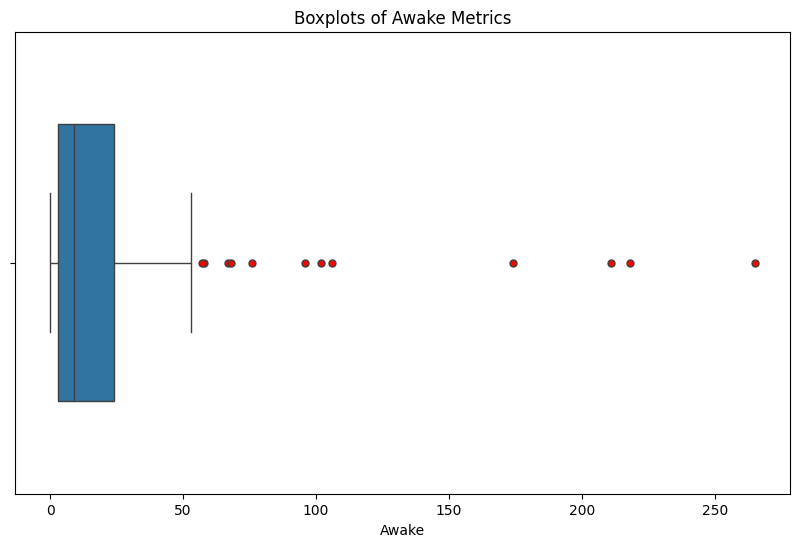

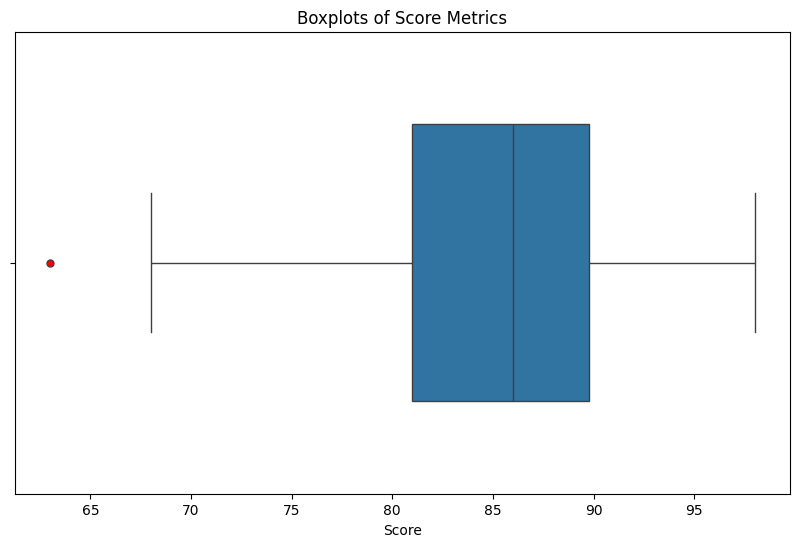

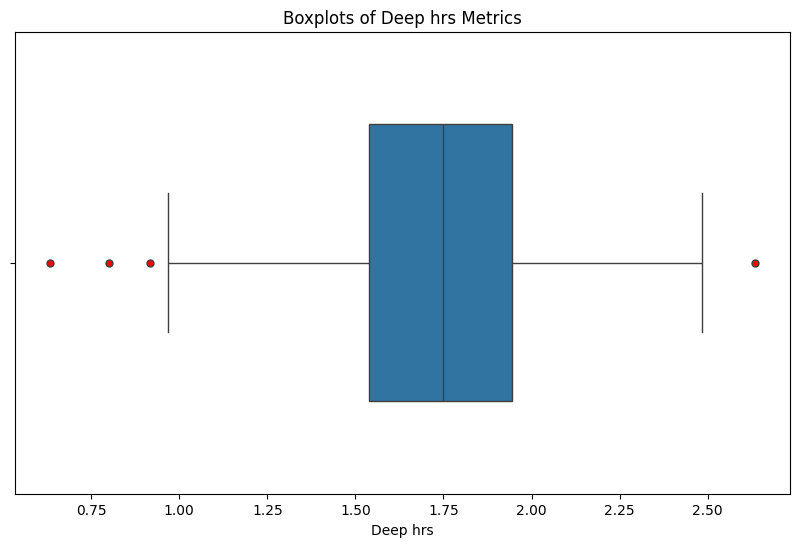

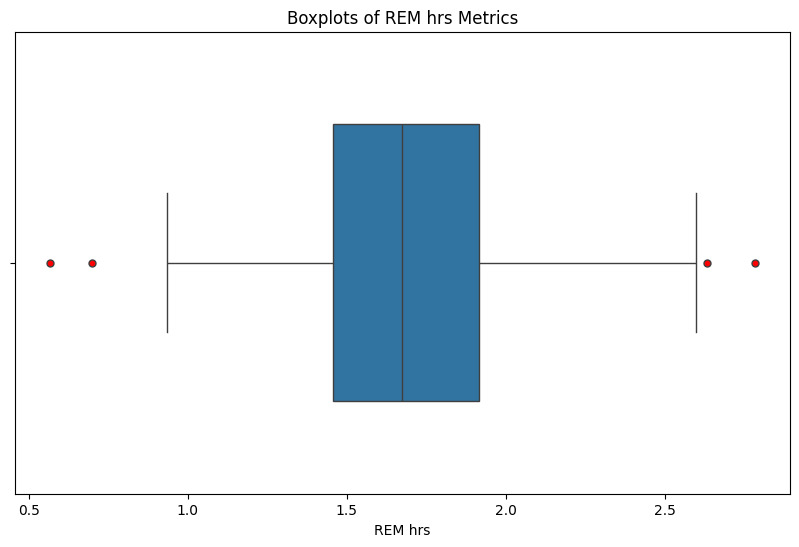

In [65]:
features = ["Stress_prev_day", "Asleep hrs", "Awake", "Score", "Deep hrs", "REM hrs"]

for feature in features:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=recovery[feature], fliersize=2, 
                flierprops=dict(markerfacecolor='r', marker='o', markersize=5), width=0.6)
    plt.title(f"Boxplots of {feature} Metrics")
    plt.show()

In [ ]:
# features = ["Stress_prev_day", "Asleep hrs", "Awake", "Score", "Deep hrs", "REM hrs"]

recovery = recovery.set_index('Date')
for feature in features:
    q3 = recovery[feature].quantile(0.75)
    q1 = recovery[feature].quantile(0.25)
    IQR = q3 - q1
    print(f"Feature: {feature}")
    print(f"  Q1: {q1}, Q3: {q3}, IQR: {IQR}")
    print(f"  Lower Bound: {q1 - 1.5 * IQR}, Upper Bound: {q3 + 1.5 * IQR}\n")
    print(f"  Outliers:")
    outliers = recovery[(recovery[feature] < q1 - 1.5 * IQR) | (recovery[feature] > q3 + 1.5 * IQR)]
    print(outliers[[feature]])
    print("length of outliers:", len(outliers))


recovery.reset_index('Date')


Feature: Stress_prev_day
  Q1: 24.0, Q3: 29.0, IQR: 5.0
  Lower Bound: 16.5, Upper Bound: 36.5

  Outliers:
            Stress_prev_day
Date                       
2025-09-29             16.0
2025-10-19             39.0
2025-10-26             39.0
2026-01-18             38.0
length of outliers: 4
Feature: Asleep hrs
  Q1: 7.225, Q3: 8.045833333333334, IQR: 0.8208333333333346
  Lower Bound: 5.993749999999998, Upper Bound: 9.277083333333337

  Outliers:
            Asleep hrs
Date                  
2025-10-05   11.400000
2025-11-03    5.183333
2025-11-17    9.483333
2025-12-06    5.533333
2025-12-26    9.916667
2025-12-27    5.400000
2026-01-10    9.816667
2026-01-24    9.833333
length of outliers: 8
Feature: Awake
  Q1: 3.0, Q3: 24.0, IQR: 21.0
  Lower Bound: -28.5, Upper Bound: 55.5

  Outliers:
            Awake
Date             
2025-10-03     76
2025-10-05    218
2025-10-13     96
2025-10-26    102
2025-11-06    174
2025-11-09     67
2025-11-10    211
2025-12-13    265
2025-12-24   

,Date,Main_x,Start,End,InBed hrs,Asleep hrs,Awake,REM hrs,Light hrs,Deep hrs,Wake Count,Efficiency,Fall Asleep,Data Source,Main_y,Start_Nap,End_Nap,Asleep_Nap,Data Source Nap,Overnight HRV,Baseline,7d Avg,Stress,RHR,Score,Resting Heart Rate,Body Battery,Pulse Ox,Respiration,HRV Status,Quality,Duration,Sleep Need,Bedtime,Wake Time,Stress_prev_day,Z Asleep hrs,Z Overnight HRV,Z Resting Heart Rate,Z Score,Z Stress_prev_day,RECOVERY_SCORE_RAW,Sigmoid Recovery Score,End_Nap_Decimal,Start_Nap_Decimal,Nap_Classifier,Nap_Duration_Score,Nap Status,Sigmoid with Nap,DELTA_NAP
0,2025-09-26,True,23:39,06:57,7.283333,7.083333,12,1.500000,3.783333,1.800000,3,97%,0.0,Connect,False,16:04,17:17,73.0,Connect,46.0,42ms - 53ms,44.0,25.0,43.0,83.0,43.0,56.0,92.86,14.70,44.0,Good,7h 5min,7h 30min,23:39:00,06:57:00,NaN,-0.010576,-0.146218,-0.346697,-0.313663,NaN,NaN,NaN,17.283333,16.066667,-0.5,0.1,Disrupt ⚠️,NaN,NaN
1,2025-09-27,True,22:43,06:31,7.800000,7.733333,3,1.950000,3.900000,1.883333,2,99%,0.0,Connect,NaN,NaN,NaN,NaN,NaN,43.0,43ms - 53ms,43.0,28.0,44.0,91.0,44.0,52.0,93.24,15.81,43.0,Excellent,7h 45min,7h 0min,22:43:00,06:31:00,25.0,0.500605,-0.873458,-0.906747,0.971591,0.343124,0.007023,0.501756,NaN,NaN,0.0,0.0,No Nap,0.501756,0.000000
2,2025-09-28,True,23:21,06:46,7.416667,7.366667,3,1.333333,4.666667,1.350000,1,99%,0.0,Connect,NaN,NaN,NaN,NaN,NaN,54.0,43ms - 53ms,44.0,16.0,43.0,92.0,43.0,65.0,94.75,15.82,44.0,Excellent,7h 22min,7h 30min,23:21:00,06:46:00,28.0,0.212246,1.793090,-0.346697,1.132248,-0.337678,0.490642,0.620258,NaN,NaN,0.0,0.0,No Nap,0.620258,0.000000
3,2025-09-29,True,21:57,06:10,8.200000,8.033333,10,2.150000,4.433333,1.433333,2,98%,0.0,Connect,NaN,NaN,NaN,NaN,NaN,56.0,43ms - 52ms,45.0,23.0,41.0,93.0,41.0,47.0,94.36,15.33,45.0,Excellent,8h 2min,8h 0min,21:57:00,06:10:00,16.0,0.736535,2.277917,0.773402,1.292905,2.385529,1.493258,0.816567,NaN,NaN,0.0,0.0,No Nap,0.816567,0.000000
4,2025-09-30,True,21:57,06:10,8.216667,8.116667,5,2.050000,4.050000,2.016667,1,99%,0.0,Connect,False,14:30,15:00,30.0,Connect,51.0,42ms - 52ms,47.0,28.0,41.0,94.0,41.0,61.0,92,15.00,47.0,Excellent,8h 8min,7h 40min,21:57:00,06:10:00,23.0,0.802071,1.065850,0.773402,1.453561,0.796992,0.978375,0.726786,15.000000,14.500000,0.5,0.5,Boost 🔥,1.000000,0.273214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2026-01-25,True,23:00,07:00,7.983333,7.816667,10,2.633333,3.500000,1.666667,1,98%,0.0,Connect,NaN,NaN,NaN,NaN,NaN,47.0,45ms-52ms,47.0,24.0,42.0,87.0,42.0,58.0,94.38,15.67,47.0,Good,7h 49min,7h 0min,23:00:00,07:00:00,26.0,0.566141,0.096196,0.213352,0.328964,0.116190,0.264169,0.565661,NaN,NaN,0.0,0.0,No Nap,0.565661,0.000000
122,2026-01-26,True,22:00,06:15,8.250000,8.033333,12,1.650000,4.866667,1.516667,2,98%,0.0,Connect,NaN,NaN,NaN,NaN,NaN,44.0,45ms-52ms,47.0,22.0,42.0,87.0,42.0,54.0,94.43,15.96,47.0,Good,8h 3min,7h 10min,22:00:00,06:15:00,24.0,0.736535,-0.631045,0.213352,0.328964,0.570058,0.243573,0.560594,NaN,NaN,0.0,0.0,No Nap,0.560594,0.000000
123,2026-01-27,True,22:34,06:15,7.683333,7.433333,14,2.050000,3.650000,1.733333,2,97%,0.0,Connect,False,14:52,15:18,26.0,Connect,49.0,45ms-52ms,47.0,21.0,41.0,89.0,41.0,52.0,93.25,14.71,47.0,Good,7h 27min,7h 30min,22:34:00,06:15:00,22.0,0.264675,0.581023,0.773402,0.650277,1.023926,0.658661,0.658959,15.300000,14.866667,0.5,0.5,Boost 🔥,1.000000,0.341041
124,2026-01-28,True,22:18,06:15,7.933333,7.800000,8,1.483333,4.466667,1.850000,2,98%,0.0,Connect,False,13:42,14:08,26.0,Connect,53.0,45ms-52ms,48.0,27.0,41.0,90.0,41.0,57.0,93.38,14.81,48.0,Excellent,7h 48min,7h 40min,22:18:00,06:15:00,21.0,0.553034,1.550677,0.773402,0.810934,1.250860,0.987781,0.728649,14.133333,13.700000,0.5,0.5,Boost 🔥,1.000000,0.271351


In [ ]:
correlation_with_outliers = recovery[features].corr()   #Correlation with outliers
correlation_with_outliers

,Stress_prev_day,Asleep hrs,Awake,Score,Deep hrs,REM hrs
Stress_prev_day,1.000000,-0.091772,0.084250,-0.183506,0.065720,-0.059811
Asleep hrs,-0.091772,1.000000,-0.031410,0.527734,0.031703,0.541477
Awake,0.084250,-0.031410,1.000000,-0.522753,-0.228798,-0.169861
Score,-0.183506,0.527734,-0.522753,1.000000,0.264489,0.566888
Deep hrs,0.065720,0.031703,-0.228798,0.264489,1.000000,0.148620
REM hrs,-0.059811,0.541477,-0.169861,0.566888,0.148620,1.000000


After removing outliers from Stress_prev_day, new data length: 87
Correlation between Stress_prev_day and Score: -0.18350594736031037



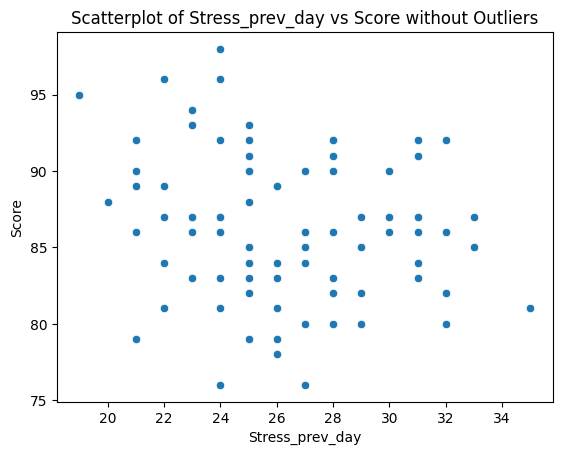

After removing outliers from Asleep hrs, new data length: 87
Correlation between Asleep hrs and Score: 0.5277341210903806



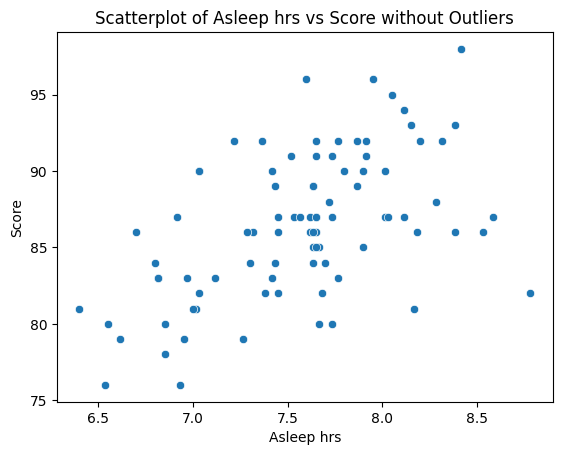

After removing outliers from Awake, new data length: 85
Correlation between Awake and Score: -0.47944384340067886



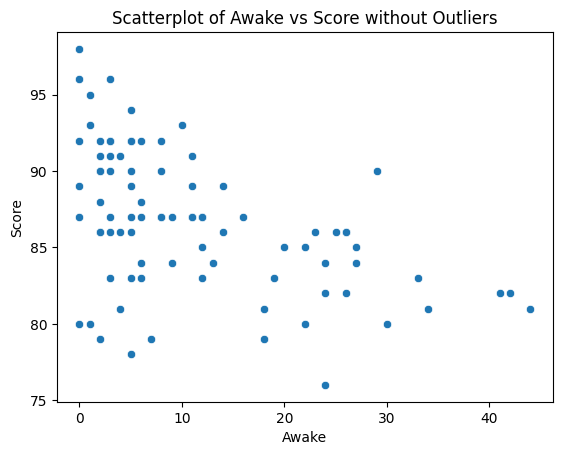

After removing outliers from Score, new data length: 85
Correlation between Score and Score: 1.0



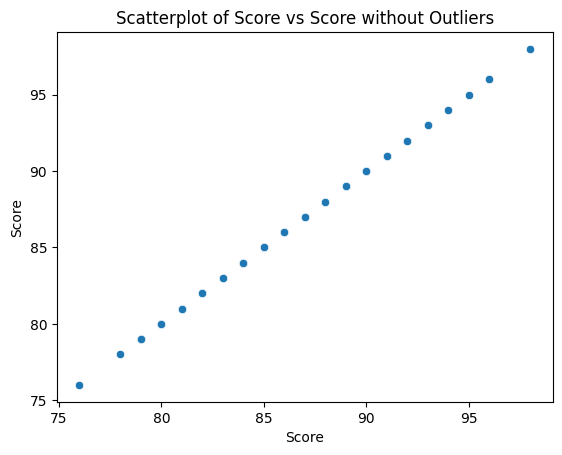

After removing outliers from Deep hrs, new data length: 85
Correlation between Deep hrs and Score: 0.26102885134347326



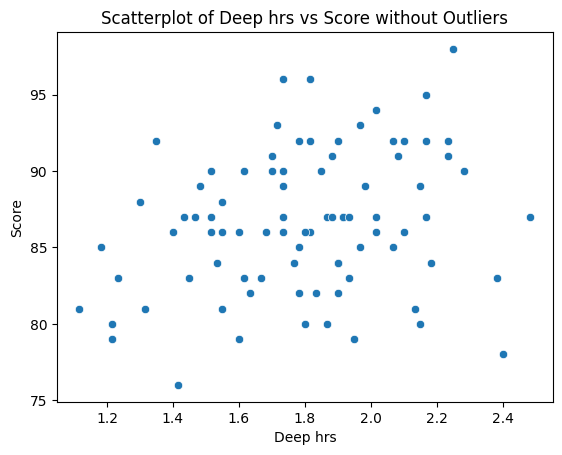

After removing outliers from REM hrs, new data length: 85
Correlation between REM hrs and Score: 0.5620123273491305



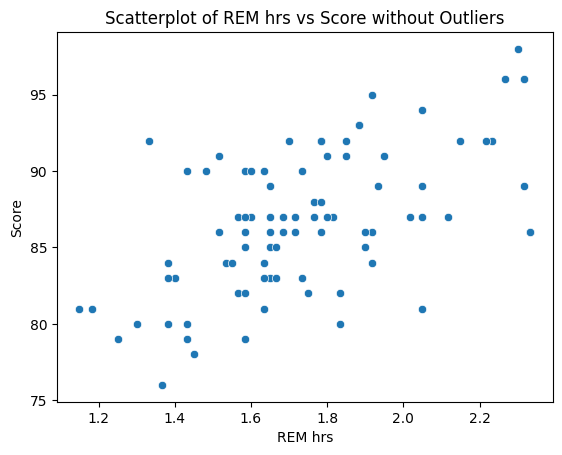

In [ ]:
# Asleep hrs, Deep hrs, REM hrs, Stress_prev_day --> SCORE
for feature in features:
    q1 = recovery[feature].quantile(0.25)
    q3 = recovery[feature].quantile(0.75)
    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    recovery = recovery[(recovery[feature] >= lower_bound) & (recovery[feature] <= upper_bound)]    #Remove outliers
    print(f"After removing outliers from {feature}, new data length: {len(recovery)}")
    print(f"Correlation between {feature} and Score: {recovery[feature].corr(recovery['Score'])}\n")    #Corr without outliers
    sns.scatterplot(data=recovery, x=feature, y="Score", hue="Quality")
    plt.title(f"Scatterplot of {feature} vs Score without Outliers")
    plt.show()